In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
SEED = 947
torch_utils.seed_everything(SEED)

In [3]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [4]:
len(tokenizer.vocab)

30522

In [5]:
tokens = tokenizer.tokenize("Hellow Howard!! How are YoU? Numan! Moon! munmun")
print(tokens)

['hello', '##w', 'howard', '!', '!', 'how', 'are', 'you', '?', 'nu', '##man', '!', 'moon', '!', 'mu', '##n', '##mun']


In [6]:
indexes = tokenizer.convert_tokens_to_ids(tokens)
print(indexes)

[7592, 2860, 4922, 999, 999, 2129, 2024, 2017, 1029, 16371, 2386, 999, 4231, 999, 14163, 2078, 23041]


In [7]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [8]:
max_input_length = tokenizer.max_model_input_sizes["bert-base-uncased"]
print(max_input_length)

512


In [9]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

In [10]:
from torchtext import data, datasets

In [11]:
TEXT = data.Field(
    batch_first=True,
    use_vocab=False,
    tokenize=tokenize_and_cut,
    preprocessing=tokenizer.convert_tokens_to_ids,
    init_token=tokenizer.cls_token_id,
    eos_token=tokenizer.sep_token_id,
    pad_token=tokenizer.pad_token_id,
    unk_token=tokenizer.unk_token_id
)
LABEL = data.LabelField(dtype=torch.float)

In [12]:
%%time
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

CPU times: user 4min 16s, sys: 1.36 s, total: 4min 17s
Wall time: 5min 46s


In [13]:
train_data, valid_data = train_data.split(random_state=random.seed(SEED), split_ratio=0.8)

In [14]:
LABEL.build_vocab(train_data)

In [15]:
%%time
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained("bert-base-uncased")
import transformers

CPU times: user 2.02 s, sys: 420 ms, total: 2.44 s
Wall time: 9.03 s


In [16]:
class SentimentalGRUBERT(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(SentimentalGRUBERT, self).__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()["hidden_size"]
        self.rnn = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers = n_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout= 0 if n_layers<2 else dropout
        )
        self.out = nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, txt):
        # batch x slength
        with torch.no_grad():
            embedded = self.bert(txt)[0]
        # batch x slength x elenght
        _, h = self.rnn(embedded)
        # h = n_layers*n_directions X batch X elength
        # _ = batch X slenght X elength*n_directions
        if self.rnn.bidirectional:
            catted = self.dropout(torch.cat((h[-2,:,:], h[-1,:,:]), dim=1))
        else:
            catted = self.dropout(h[-1,:,:])
        
        # catted = batch X hidden
        return self.out(catted)

In [17]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds==y).float()
    return correct.sum()/len(correct)

In [18]:
def train(model, iterator, optimizier, criterion):
    l,a = 0,0
    model.train()
    
    for batch in tqdm(iterator):
        optimizier.zero_grad()
        preds = model(batch.text).squeeze(dim=1)
        loss = criterion(preds, batch.label)
        acc = binary_accuracy(preds, batch.label)
        loss.backward()
        optimizer.step()
        l+=loss.item()
        a+=acc.item()
    return l/len(iterator), a/len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    l,a = 0,0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(iterator):
            preds = model(batch.text).squeeze(dim=1)
            loss = criterion(preds, batch.label)
            acc = binary_accuracy(preds, batch.label)
            l+=loss.item()
            a+=acc.item()
    return l/len(iterator), a/len(iterator)

In [35]:
BATCH_SIZE = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
(train_data, valid_data, test_data),
batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
device=device
)

HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3

model = SentimentalGRUBERT(bert,HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

for name, param in model.named_parameters():
    if name.startswith("bert"):
        param.requires_grad = False
model = model.to(device)


torch_utils.clear_cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch_utils.RAdam(model.parameters())

In [37]:
N_EPOCHS = 30
ea = torch_utils.EarlyStopping(patience=10, verbose=True)
lrs = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
history = pd.DataFrame()

for e in range(N_EPOCHS):
    print("Epoch {} learning rate: {}".format(e+1, torch_utils.get_lr(optimizer)))
    torch_utils.clear_cuda()
    st = time.time()
    tl, ta = train(model, train_iterator, optimizer, criterion)
    vl, va = evaluate(model, valid_iterator, criterion)
    ea(vl, model)
    lrs.step(vl)
    
    history = torch_utils.print_epoch_stat(e, time.time()-st, history, tl, ta, vl, va)

Epoch 1 learning rate: 0.001



Found better solution (inf --> 0.358071).  Saving model ...


EPOCH 1 Completed, Time Taken: 0:10:57.227310
	Train Loss 	0.552808455
	Train Accuracy 	70.1544611%
	Valid Loss 	0.358070884
	Valid Accuracy 	85.9682564%
Epoch 2 learning rate: 0.001



Found better solution (0.358071 --> 0.248780).  Saving model ...


EPOCH 2 Completed, Time Taken: 0:10:50.624728
	Train Loss 	0.320072571
	Train Accuracy 	86.9481835%
	Valid Loss 	0.248779595
	Valid Accuracy 	89.7698432%
Epoch 3 learning rate: 0.001



Found better solution (0.248780 --> 0.221174).  Saving model ...


EPOCH 3 Completed, Time Taken: 0:10:51.494202
	Train Loss 	0.254365872
	Train Accuracy 	89.7234702%
	Valid Loss 	0.221174148
	Valid Accuracy 	91.1428591%
Epoch 4 learning rate: 0.001



Found better solution (0.221174 --> 0.219314).  Saving model ...


EPOCH 4 Completed, Time Taken: 0:10:51.443665
	Train Loss 	0.228369355
	Train Accuracy 	90.9043371%
	Valid Loss 	0.219313503
	Valid Accuracy 	91.2103196%
Epoch 5 learning rate: 0.001



Found better solution (0.219314 --> 0.215084).  Saving model ...


EPOCH 5 Completed, Time Taken: 0:10:51.849328
	Train Loss 	0.212831977
	Train Accuracy 	91.6292992%
	Valid Loss 	0.215084402
	Valid Accuracy 	91.8412719%
Epoch 6 learning rate: 0.001



EarlyStopping counter: 1 out of 10


EPOCH 6 Completed, Time Taken: 0:10:47.771732
	Train Loss 	0.188351581
	Train Accuracy 	92.727954%
	Valid Loss 	0.21660568
	Valid Accuracy 	91.6428592%
Epoch 7 learning rate: 0.001



EarlyStopping counter: 2 out of 10


EPOCH 7 Completed, Time Taken: 0:10:46.542849
	Train Loss 	0.177419075
	Train Accuracy 	93.0393639%
	Valid Loss 	0.228148117
	Valid Accuracy 	91.2579387%
Epoch 8 learning rate: 0.001



EarlyStopping counter: 3 out of 10


EPOCH 8 Completed, Time Taken: 0:10:44.708308
	Train Loss 	0.14606196
	Train Accuracy 	94.4394638%
	Valid Loss 	0.264098073
	Valid Accuracy 	91.1944463%
Epoch 9 learning rate: 0.001



EarlyStopping counter: 4 out of 10


EPOCH 9 Completed, Time Taken: 0:10:44.594295
	Train Loss 	0.126544049
	Train Accuracy 	95.3537637%
	Valid Loss 	0.270367988
	Valid Accuracy 	91.1111127%
Epoch 10 learning rate: 0.001


KeyboardInterrupt: 

In [38]:
torch_utils.clear_cuda()

In [39]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print("Possible 'Overfitted' model stats")
print("Loss: {:0.5}".format(test_loss))
print("Accuracy: {:0.5}%".format(100.0*test_acc))


Possible 'Overfitted' model stats
Loss: 0.25125
Accuracy: 90.124%


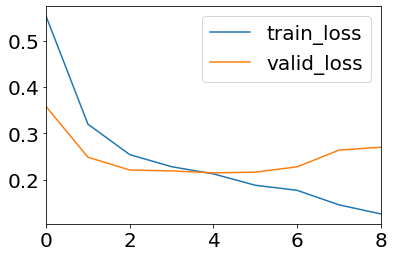

In [40]:
ax = history["train_loss"].plot()
history["valid_loss"].plot(ax=ax)
plt.legend()

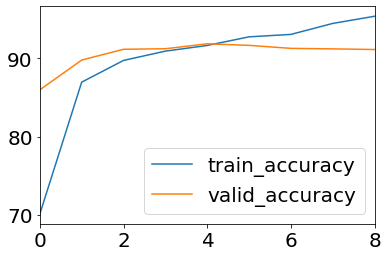

In [41]:
ax = history["train_accuracy"].plot()
history["valid_accuracy"].plot(ax=ax)
plt.legend()

In [42]:
model.load_state_dict(torch.load("checkpoint.pt", map_location=device))
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print("Model with best validation loss: stats")
print("Loss: {:0.5}".format(test_loss))
print("Accuracy: {:0.5}%".format(100.0*test_acc))


Model with best validation loss: stats
Loss: 0.19888
Accuracy: 92.174%


In [43]:
torch_utils.clear_cuda()

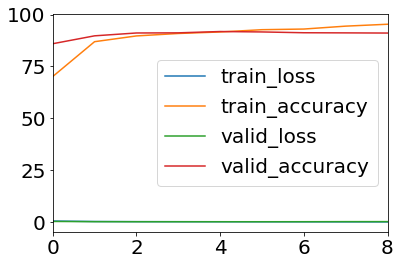

In [44]:
history.head()